In [1]:
!rm -rf neighborhoods
!rm *.zip
!conda install -q -y ffmpeg

rm: cannot remove ‘*.zip’: No such file or directory
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [2]:
!wget https://dl3.pushbulletusercontent.com/uUN2AiPUxxvqfJlWaWhbhNQdZVrprSBu/code.zip
!unzip code.zip
!rm EC.py
!rm mnca.py

--2023-04-20 06:23:46--  https://dl3.pushbulletusercontent.com/uUN2AiPUxxvqfJlWaWhbhNQdZVrprSBu/code.zip
Resolving dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)... 35.208.62.122
Connecting to dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)|35.208.62.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4934 (4.8K) [application/x-zip-compressed]
Saving to: ‘code.zip’

100%[======================================>] 4,934       --.-K/s   in 0s      

2023-04-20 06:23:47 (54.2 MB/s) - ‘code.zip’ saved [4934/4934]

Archive:  code.zip
  inflating: EC.py                   
  inflating: mnca.py                 
  inflating: neighborhoods/mask_c1.txt  
  inflating: neighborhoods/mask_c2.txt  
  inflating: neighborhoods/mask_c3.txt  


In [3]:
rule = [[(0.451, 0.713, 0), (0.449, 0.663, 1), (0.191, 0.52, 1), (0.089, 0.296, 0)], [(0.332, 0.51, 0), (0.084, 0.307, 0), (0.182, 0.465, 1)], [(0.799, 0.902, 0), (0.303, 0.456, 0), (0.835, 0.984, 1)]]

# FOR EC - Results available here - https://github.com/s4nyam/emnca/blob/main/emnca/p10g50_1.ipynb



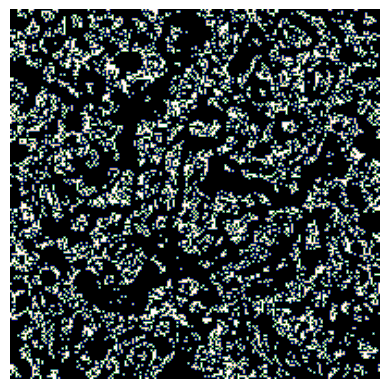

In [4]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)


############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
def blockshaped(arr, nrows, ncols):
    
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def FrequencyHistogramCoarseGraining(array):
    # Let us split NxN array to smaller 2x2 blcks
    super_cells_list =  []
    new_board = []
    threshold1 = 0.03
    # what are the lower limits of thresh and upper limits of thresh?
    # threshold2 = 0.06 # For multi state MNCA
    
    # given block shape of 2,2 says that we have a chunk of 2x2 that partitions complete w,h
    array = blockshaped(array,2,2)
    for each_sub_array in array:
        super_cells_list.append(list(each_sub_array.flatten()))
    for i in range(len(super_cells_list)):
        count = 0
        for j in range(len(super_cells_list)):
            if(super_cells_list[i]==super_cells_list[j]):
                count = count+1 # count is number of blocks matching in the same grid (ref literature)

                # also lists are equal when every elemenet is equal and at correrct index
                # >>> [1,2,3,4] == [2,1,3,4]
                # False
                # >>> [1,2,3,4] == [1,2,3,4]
                # True

        new_board.append(count/len(super_cells_list))
    for i in range(len(new_board)):
        if(new_board[i] < threshold1):
            new_board[i] = 1
        else: 
            # new_board[i] >= threshold1):
            new_board[i] = 0
            
    modified_board = np.array(new_board)
    shape = int(np.sqrt(len(new_board)))
    # print(shape)
    modified_board = modified_board.reshape(shape,shape)
    return modified_board
############# FHCG SECTION ##############    
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############





def init_board(width, height, init_state):
    if init_state == "single cell in center":
        board = np.zeros((height, width), dtype=np.int)
        board[height//2, width//2] = 1
    elif init_state == "random cells with some probability":
        p = 0.250 # probability of a cell being alive
        board = np.random.choice([0, 1], size=(height, width), p=[1-p, p])
    elif init_state == "random cells with 2 different states":
        p1 = 0.250 # probability of a cell being state 1
        board = np.random.choice([0, 1, 2], size=(height, width), p=[1-p1, p1/2, p1/2])
    else:
        raise ValueError("Invalid initial state")
    return board


def update(frame, img, board, neighborhoods, range_of_neighborhood_sums):
    new_board = np.zeros_like(board, dtype=int)
    height, width = board.shape
    for i in range(height):
        for j in range(width):
            next_state = board[i, j]
            for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                     for ni, nj in neighborhood]
                
                # # use this for sum
                # neighborhood_sum = sum(cell_neighborhood)
                
                # use this for average
                neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                for lower, upper, new_next_state in range_of_neighborhood_sum:
                    if lower <= neighborhood_sum <= upper:
                        next_state = new_next_state
            new_board[i, j] = next_state
    board[:] = new_board[:]
    board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
    img.set_data(board)
    return img,

def run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums):
    board = init_board(width, height, init_state)
    fig, ax = plt.subplots()
    plt.axis('off')
    img = ax.imshow(board, cmap='gist_earth')
    ani = animation.FuncAnimation(fig, update, frames=steps, fargs=(img, board, neighborhoods, range_of_neighborhood_sums), repeat=False)
    # ani.save(filename, dpi=80, writer='imagemagick')
    ani.save(filename, dpi=200, writer='ffmpeg', codec='h264')



def extract_neighborhood_from_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
        neighborhood = []
        for i, line in enumerate(lines):
            line = line.strip()
            for j, value in enumerate(line.split(" ")):
                if value == "1":
                    neighborhood.append((i-1, j-1))
        return neighborhood


width = 400
height = 400
steps = 100
init_state = "random cells with some probability"




nh1 = extract_neighborhood_from_file('neighborhoods/mask_c1.txt')
nh2 = extract_neighborhood_from_file('neighborhoods/mask_c2.txt')
nh3 = extract_neighborhood_from_file('neighborhoods/mask_c3.txt')
neighborhoods = [nh1,nh2,nh3]
range_of_neighborhood_sums=rule



filename = "thresh_0.03.mp4"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
